In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').show();
 } else {
 $('div.input').hide();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive, Layout
import ipywidgets as widgets
import scipy.stats as ss
import json
%matplotlib notebook

import plotly
import susipop as sp
import pylab
from decimal import Decimal
import warnings
warnings.filterwarnings('ignore')

/home/vsivadas/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/vsivadas/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def get_folder_list(path="."):
    f = next(os.walk(path))[1]
    return f
def sort_data(x,y):
    lists = sorted(itertools.izip(*[x, y]))
    new_x, new_y = list(itertools.izip(*lists))
    return new_x, new_y
def LoadJSON(filename):
    file = open(filename)
    string = file.read()
    file.close()
    return json.loads(string)
def get_phi_yd_nuf(path_add):
    config = LoadJSON(path_add+'/config.json')
    fluid = LoadJSON(path_add+'/fluid_1.json')
    shearrate = config["experiment"]["shearrate"]["constant"]["yd"]
    phi=config["material"]["particles"]["0"]["phi"]
    nu_fluid = fluid["viscshear"]["constant"]["nu"]*1000
    return phi,shearrate,nu_fluid 

In [3]:
# Comparison of time series data of viscosity

In [4]:
def plot_timeseries(phivals,ydvals,path_text_input1,path_text_input2,path_text_input3,path_text_input4,x_lim):
    plt.style.use('ggplot')
    l = []
    if len(path_text_input1.strip())!= 0:
        path_add1 = str(path_text_input1)
    else:
        path_add1 = "./"
    if len(path_text_input2.strip())!= 0:
        path_add2 = str(path_text_input2)
    else:
        path_add2 = ""
    if len(path_text_input3.strip())!= 0:
        path_add3 = str(path_text_input3)
    else:
        path_add3 = ""
    if len(path_text_input4.strip())!= 0:
        path_add4 = str(path_text_input4)
    else:
        path_add4 = ""
        
    plt.figure(figsize=[12,5])
    minshear = 100000
    for path_add in [path_add1,path_add2,path_add3,path_add4]:
        if path_add != "":
            for p in phivals:
                for s in ydvals:
                    f = path_add+"rhor1_phi"+str(p)+"_yd"+str(float(s))+"/result/nu_t.dat"
                    try:
                        db = pd.read_csv(f)
                        nu = db[db.columns[2]]
                        nu_rel = db[db.columns[4]]
                        t = db[db.columns[1]]
                        shearrate = s
                        shear = t*shearrate
                        if minshear > shear.max(): minshear = shear.max()
#                         plt.plot(shear,nu_rel,label="$\phi=$ "+str(p)+" $\dot{\gamma}=$ "+str(shearrate)+" "+path_add)
                        plt.plot(shear,nu_rel,label="$\phi=$ "+str(p)+" $\dot{\gamma}=$ "+str(shearrate)+ " "+ path_add)
                        print np.mean(nu_rel), np.std(nu_rel)
                    except:
                        continue
    plt.legend(loc="best",fontsize=12)
#     plt.title(f.split("/")[0].split("yd")[0])
    plt.yscale("log")
    plt.xlabel("strain",fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Relative viscosity",fontsize=18)
    plt.xlim([x_lim[0],x_lim[1]])

#     plt.xlim([0,minshear])
#     name = "comparison_viscosity_" + str(phival)+ '_'.join([str(i) for i in ydvals])
#     plt.savefig(name)

plot_timeseries_widget = interactive(plot_timeseries, \
                phivals = widgets.SelectMultiple(options=[20,30,40,45,50,54,55,56,58],value = [56],disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,2,3,4,5,6,7,8,9,10,10.5,10.525,10.55,10.575,10.6,10.75,11,11.5,12,12.5,13,14,15,16,18,20,24,25,30,50,70,100,200,300,1000,2000,5000,10000]),\
                path_text_input1 = widgets.Text(value="../F_CL_2e-10/",layout=Layout(width='40%', height='200%')),\
                path_text_input2 = widgets.Text(value="larger_system_size/from_cartesius/F_CL_2e-10/",layout=Layout(width='40%', height='200%')),\
                path_text_input3 = widgets.Text(value="larger_viscosity/from_cartesius/",layout=Layout(width='40%', height='200%')),\
                path_text_input4 = widgets.Text(value="larger_viscosity/from_cartesius/",layout=Layout(width='40%', height='200%')),\
                x_lim = widgets.FloatRangeSlider(value = [0,10], min =0, max =100),
                __manual=False)

# display(plot_timeseries_widget)

In [5]:
def plot_timeseries_multiple_sources(path_text_input1,path_text_input2,path_text_input3,path_text_input4,x_lim):
    plt.style.use('ggplot')
    l = []
    if len(path_text_input1.strip())!= 0:
        path_add1 = str(path_text_input1)
    else:
        path_add1 = "./"
    if len(path_text_input2.strip())!= 0:
        path_add2 = str(path_text_input2)
    else:
        path_add2 = ""
    if len(path_text_input3.strip())!= 0:
        path_add3 = str(path_text_input3)
    else:
        path_add3 = ""
    if len(path_text_input4.strip())!= 0:
        path_add4 = str(path_text_input4)
    else:
        path_add4 = ""
        
    plt.figure(figsize=[12,5])
    minshear = 100000
    titletext = "comparison between "
    for path_add in [path_add1,path_add2,path_add3,path_add4]:
        if path_add != "":
            f = path_add+"/result/nu_t.dat"
            try:
                db = pd.read_csv(f)
                nu = db[db.columns[2]]
                nu_rel = db[db.columns[4]]
                t = db[db.columns[1]]
                phi,shearrate,nu_fluid = get_phi_yd_nuf(path_add)
                nu_fluid = '%.3E' % Decimal(str(nu_fluid))
                shear = t*shearrate
                if minshear > shear.max(): minshear = shear.max()
                labeltext = "$\phi$="+str(phi)+"  $\dot{\gamma}$="+str(shearrate)+ "/s  $\\nu_{fluid}$ ="+str(nu_fluid)+" Pa.s"
                mean_nu, std_dev_nu = np.round(np.mean(nu_rel)),np.round(np.std(nu_rel))
                _labeltext = labeltext+ "\n $\mu_{viscosity}$  ~"+str(mean_nu)+ " $\sigma_{viscosity}$  ~"+str(std_dev_nu)
                titletext+="("+labeltext+")," 
                plt.plot(shear,nu_rel,label=_labeltext)
            except Exception as e:
                print e
                continue
    plt.legend(loc="best",fontsize=12)
#     plt.title(f.split("/")[0].split("yd")[0])
    plt.yscale("log")
    plt.xlabel("strain",fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Relative viscosity",fontsize=18)
    plt.title(titletext,fontsize=12)
    plt.xlim([x_lim[0],x_lim[1]])
    plt.tight_layout()

#     plt.xlim([0,minshear])
#     name = "comparison_viscosity_" + str(phival)+ '_'.join([str(i) for i in ydvals])
#     plt.savefig(name)

plot_timeseries_multiple_sources_widget = interactive(plot_timeseries_multiple_sources, \
                path_text_input1 = widgets.Text(value="./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/rhor1_phi56_yd15.0",layout=Layout(width='40%', height='200%')),\
                path_text_input2 = widgets.Text(value="./larger_viscosity/larger_viscosity_0.5x_F_CL_2e-10/rhor1_phi56_yd30.0",layout=Layout(width='40%', height='200%')),\
                path_text_input3 = widgets.Text(value="",layout=Layout(width='40%', height='200%')),\
                path_text_input4 = widgets.Text(value="",layout=Layout(width='40%', height='200%')),\
                x_lim = widgets.FloatRangeSlider(value = [0,10], min =0, max =100),
                __manual=True)

display(plot_timeseries_multiple_sources_widget)

# plot_flow_curves rel.viscosity vs shearrate

In [6]:
def plot_flow_curve_get_data_shearrate(paths_input):
    data = []
    valid_paths = []
    for path in paths_input:
        if os.path.exists(path) and os.path.exists(path+"/result/nu_t.dat"):
            try:
                phi,yd,nu_f=get_phi_yd_nuf(path)
                f = path+"/result/nu_t.dat"
                db = pd.read_csv(f)
                nu = db[db.columns[2]][100:]
                nu_rel = db[db.columns[4]][100:]
                data.append([phi,yd,nu_f,nu.mean(),nu.std(),nu_rel.mean(),nu_rel.std()])
                valid_paths.append(path)
            except Exception as e: 
                print e
                continue
    return valid_paths, np.asarray(data)
def plot_flow_curve_plot_data_shearrate(paths_input):
    paths, data = plot_flow_curve_get_data_shearrate(paths_input)
    print len(data.T[0]), " data points"
    sources = [i.split("rhor")[:-1][0] for i in paths]
    uniq_sources = list(set([i.split("rhor")[:-1][0] for i in paths]))
    source_dict = dict()
    source_dict_reverse = dict()
    for i,item in enumerate(uniq_sources): source_dict[item] = i
    for i,item in enumerate(uniq_sources): source_dict_reverse[i] = item

    source_idx = np.array([source_dict[i] for i in sources])
    plt.figure(figsize=[12,6])
    marker = itertools.cycle(( 'o', '^', '*', 'v')) 
    for k in source_dict.values():
        uniq_idx = np.where(source_idx==k)[0]
        source_name = source_dict_reverse[k]
#         print uniq_idx
        fmt = marker.next()
        for i,p in enumerate(np.unique(data.T[0][uniq_idx])):
            idx = np.where(data.T[0][uniq_idx] == p)[0]
#             print data.T[5][uniq_idx][idx]
#             print data.T[1][uniq_idx][idx]
            plt.errorbar(x = data.T[1][uniq_idx][idx], y = data.T[5][uniq_idx][idx], yerr=data.T[6][uniq_idx][idx], \
                         ls='-',fmt= fmt, label = "$\phi=$"+str(p)+"source={0} ,\nfluid viscosity={1} Pa.s".format(source_name,str(data.T[2][uniq_idx][idx][0])))
#             plt.plot(data.T[1][uniq_idx][idx],  data.T[5][uniq_idx][idx],'-')
#             plt.errorbar(x = data.T[1][uniq_idx][idx], y = data.T[5][uniq_idx][idx], yerr=data.T[6][uniq_idx][idx],
#                          fmt= fmt, label = "$\phi=$"+str(p)+",\nsource="+source_name)
    plt.legend(fontsize=12,ncol=2,loc='best')
#      bbox_to_anchor=(0.25,1),
    plt.xlabel("shearrate 1/s",fontsize=12)
    plt.ylabel("relative viscosity",fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xscale("log")
    plt.yscale("log")
    

# plot flow curves rel.viscosity vs shear stress

In [7]:
def plot_flow_curve_get_data_shearstress(paths_input):
    data = []
    valid_paths = []
    for path in paths_input:
        if os.path.exists(path) and os.path.exists(path+"/result/nu_t.dat"):
            try:
                phi,yd,nu_f=get_phi_yd_nuf(path)
                f = path+"/result/nu_t.dat"
                db = pd.read_csv(f)
                nu = np.array(db[db.columns[2]][100:])
                nu_rel = np.array(db[db.columns[4]][100:])
                shearstress = yd*nu
                #uncomment for mean data
                data.append([phi, yd, nu_f, nu.mean(), nu.std(), nu_rel.mean(), nu_rel.std(),shearstress.mean(),shearstress.std()])
                valid_paths.append(path)
                #uncomment for all data
#                 for i in range(len(nu)):
#                     data.append([phi,yd,nu_f,nu[i],nu.std(),nu_rel[i],nu_rel.std(),shearstress[i],shearstress.std()])
#                     valid_paths.append(path)
            except Exception as e: 
                print e
                continue
#     print data
    return valid_paths, np.asarray(data)
def plot_flow_curve_plot_data_shearstress(paths_input):
    paths, data = plot_flow_curve_get_data_shearstress(paths_input)
#     print data
    print len(data.T[0]), " data points"
    sources = [i.split("rhor")[:-1][0] for i in paths]
    uniq_sources = list(set([i.split("rhor")[:-1][0] for i in paths]))
    source_dict = dict()
    source_dict_reverse = dict()
    for i,item in enumerate(uniq_sources): source_dict[item] = i
    for i,item in enumerate(uniq_sources): source_dict_reverse[i] = item

    source_idx = np.array([source_dict[i] for i in sources])
    plt.figure(figsize=[12,6])
    marker = itertools.cycle(( 'o', '^', '*', 'v')) 
    for k in source_dict.values():
        uniq_idx = np.where(source_idx==k)[0]
        source_name = source_dict_reverse[k]
#         print uniq_idx
        fmt = marker.next()
        for i,p in enumerate(np.unique(data.T[0][uniq_idx])):
            idx = np.where(data.T[0][uniq_idx] == p)[0]
            #uncomment to plot mean data
            plt.errorbar(x = data.T[7][uniq_idx][idx], y = data.T[5][uniq_idx][idx], yerr=data.T[6][uniq_idx][idx],
                         fmt= fmt, label = "$\phi=$"+str(p)+"source={0} ,\nfluid viscosity={1} Pa.s".format(source_name,str(data.T[2][uniq_idx][idx][0])))
#             plt.errorbar(x = data.T[7][uniq_idx][idx], y = data.T[5][uniq_idx][idx], yerr=data.T[6][uniq_idx][idx],
#                          fmt= fmt, label = "$\phi=$"+str(p)+"\nsource="+source_name)
            #uncomment to plot all data
#             plt.plot(data.T[7][uniq_idx][idx], data.T[5][uniq_idx][idx], '.',label = "$\phi=$"+str(p)+"\nsource="+source_name)
    plt.legend(fontsize=8,ncol=1,loc='best')
#      bbox_to_anchor=(0.25,1),
    plt.xlabel("shear stress Pa")
    plt.ylabel("rel. viscosity")
    plt.xscale("log")
    plt.yscale("log")
#     plt.plot(np.linspace(1e-1,1e2,1000),np.linspace(1e1,1e4,1000),'k--', label="slope=1")
    plt.tight_layout()


[u'seaborn-darkgrid', u'seaborn-notebook', u'seaborn-muted', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'classic', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']
62  data points


<IPython.core.display.Javascript object>


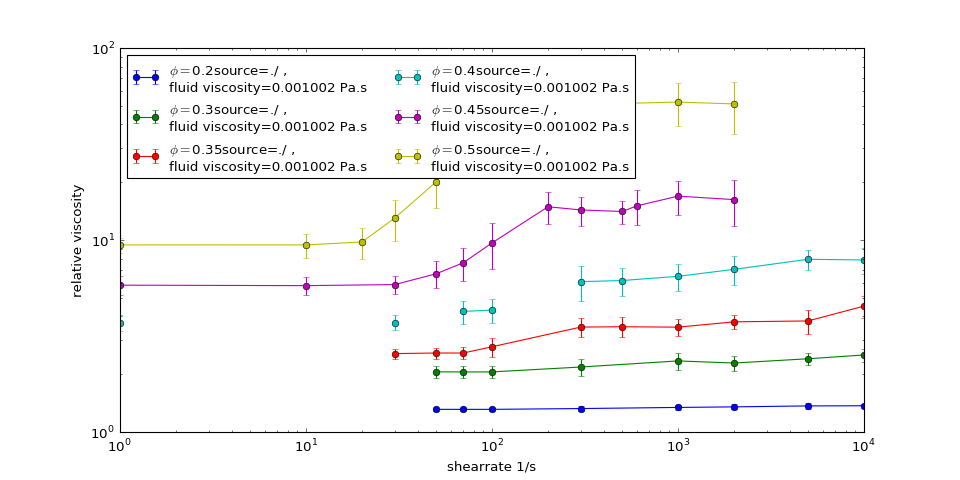

In [8]:
paths_input  = []
# phivals = [20,30,35,56]
phivals = [20,30,35, 40, 45,50]
ydvals = np.arange(0,10001,0.5)
paths_input += ["./rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_0.5x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_2x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_4x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+=  ["./larger_viscosity/test_smaller_repulsion_layer_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+=  ["./larger_viscosity/pentapole/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]

# paths_input+= ["./larger_viscosity/larger_viscosity_10x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# plot_flow_curve_get_data_shearstress(paths_input)
print plt.style.available
plt.style.use('classic')
# plot_flow_curve_plot_data_shearstress(paths_input)
plot_flow_curve_plot_data_shearrate(paths_input)


# viscosity contribution from individual components vs shearrate

In [9]:
def plot_flow_curve_get_data_shearrate_components(paths_input,component):
    data = []
    valid_paths = []
    if component in ["fluid_stress_t.dat", "part_stress_fric_t.dat", "part_stress_intfluid_t.dat", "part_stress_tot_t.dat", "part_stress_hd_t.dat", "part_stress_lub_t.dat",  "part_stress_rep_t.dat"]:
        components_col = 2
    else:
        components_col = 3
    if component=="nu_t.dat":
        components_col = 2
    for path in paths_input:
        if os.path.exists(path) and os.path.exists(path+"/result/"+component):
            try:
                phi,yd,nu_f=get_phi_yd_nuf(path)
                f = path+"/result/{}".format(component)
                db = pd.read_csv(f)
                val = db[db.columns[components_col]][100:]
                if component!="nu_t.dat": val/=yd
#                 val/=nu_f
                data.append([phi,yd,nu_f,val.mean(),val.std()])
                valid_paths.append(path)
            except Exception as e: 
                print e
                continue
    return valid_paths, np.asarray(data)

def plot_flow_curve_plot_data_shearrate_components(paths_input,component):
    paths, data = plot_flow_curve_get_data_shearrate_components(paths_input,component)
    print len(data.T[0]), " data points"
    sources = [i.split("rhor")[:-1][0] for i in paths]
    uniq_sources = list(set([i.split("rhor")[:-1][0] for i in paths]))
    source_dict = dict()
    source_dict_reverse = dict()
    for i,item in enumerate(uniq_sources): source_dict[item] = i
    for i,item in enumerate(uniq_sources): source_dict_reverse[i] = item
    source_idx = np.array([source_dict[i] for i in sources])
    marker = itertools.cycle(( 'o', '^', '*', 'v')) 
    for k in source_dict.values():
        uniq_idx = np.where(source_idx==k)[0]
        source_name = source_dict_reverse[k]
#         print uniq_idx
        fmt = marker.next()
        for i,p in enumerate(np.unique(data.T[0][uniq_idx])):
            idx = np.where(data.T[0][uniq_idx] == p)[0]
            plt.errorbar(x = data.T[1][uniq_idx][idx], y = data.T[3][uniq_idx][idx], yerr=data.T[4][uniq_idx][idx],
                         fmt= fmt, label = component+" $\phi=$"+str(p)+",\nfluid viscosity={} Pa.s".format(str(data.T[2][uniq_idx][idx][0])))
#             plt.errorbar(x = data.T[1][uniq_idx][idx], y = data.T[3][uniq_idx][idx], yerr=data.T[4][uniq_idx][idx],
#                          fmt= fmt, label = "$\phi=$"+str(p)+",\nsource="+source_name)
    plt.legend(fontsize=8,ncol=4,loc='upper left')
#      bbox_to_anchor=(0.25,1),
    plt.xlabel("shearrate 1/s")
    plt.xscale("log")
    plt.yscale("log")
#     plt.ylim([1e-1,1e6])
paths_input  = []
# phivals = [40,45,50,54,55,56]
phivals = [50]
ydvals = np.arange(0,1000,0.5)
# paths_input += ["./rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_0.5x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_2x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_4x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_10x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+=  ["./larger_viscosity/test_smaller_repulsion_layer_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
paths_input+=  ["./larger_viscosity/test_pentapole_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]

# plot_flow_curve_plot_data_shearrate(paths_input,"part_stress_lub_t.dat")
# plot_flow_curve_plot_data_shearrate(paths_input,"nu_t.dat")
plt.figure(figsize=[12,10])
# plt.figure(figsize=[12,10],dpi=300)
# plot_flow_curve_plot_data_shearrate_components(paths_input,"nu_t.dat")
plot_flow_curve_plot_data_shearrate_components(paths_input,"part_stress_lub_t.dat")
plot_flow_curve_plot_data_shearrate_components(paths_input,"part_stress_fric_t.dat")
plot_flow_curve_plot_data_shearrate_components(paths_input,"part_stress_rep_t.dat")
# plot_flow_curve_plot_data_shearrate_components(paths_input,"part_stress_tot_t.dat")
plot_flow_curve_plot_data_shearrate_components(paths_input,"part_stress_hd_t.dat")

<IPython.core.display.Javascript object>

IndexError: index 0 is out of bounds for axis 0 with size 0

# individual stress components vs shear stress

<IPython.core.display.Javascript object>


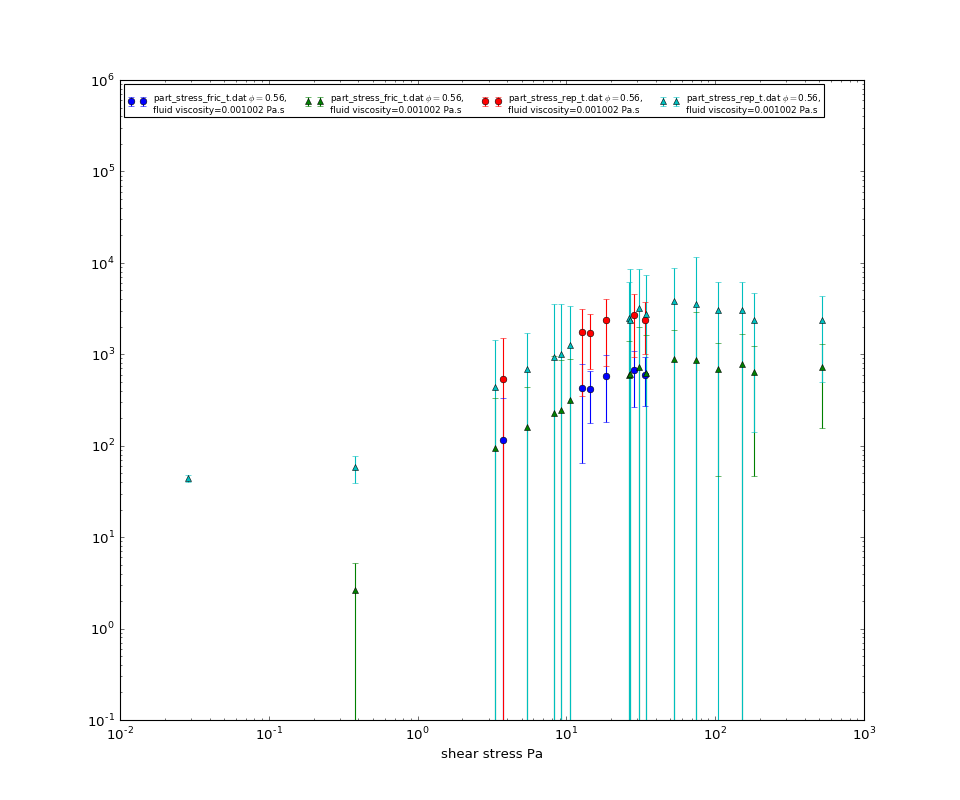

23  data points
23  data points


In [13]:
def plot_flow_curve_get_data_shearstress_components(paths_input,component):
    data = []
    valid_paths = []
    if component in ["fluid_stress_t.dat", "part_stress_fric_t.dat", "part_stress_intfluid_t.dat", "part_stress_tot_t.dat", "part_stress_hd_t.dat", "part_stress_lub_t.dat",  "part_stress_rep_t.dat"]:
        components_col = 2
    else:
        components_col = 3
    if component=="nu_t.dat":
        components_col = 2
    for path in paths_input:
        if os.path.exists(path) and os.path.exists(path+"/result/"+component):
            try:
                phi,yd,nu_f=get_phi_yd_nuf(path)
                f = path+"/result/{}".format(component)
                db = pd.read_csv(f)
                val = db[db.columns[components_col]][100:]
                if component!="nu_t.dat": val/=yd
                val/=nu_f
                f_ss = path+"/result/nu_t.dat"
                db_ss = pd.read_csv(f_ss)
                nu = np.array(db_ss[db_ss.columns[2]][100:])
                shearstress = yd*nu
                
                data.append([phi,yd,nu_f,val.mean(),val.std(),shearstress.mean(), shearstress.std()])
                valid_paths.append(path)
            except Exception as e: 
                print e
                continue
    return valid_paths, np.asarray(data)

def plot_flow_curve_plot_data_shearstress_components(paths_input,component):
    paths, data = plot_flow_curve_get_data_shearstress_components(paths_input,component)
    print len(data.T[0]), " data points"
    sources = [i.split("rhor")[:-1][0] for i in paths]
    uniq_sources = list(set([i.split("rhor")[:-1][0] for i in paths]))
    source_dict = dict()
    source_dict_reverse = dict()
    for i,item in enumerate(uniq_sources): source_dict[item] = i
    for i,item in enumerate(uniq_sources): source_dict_reverse[i] = item
    source_idx = np.array([source_dict[i] for i in sources])
    marker = itertools.cycle(( 'o', '^', '*', 'v')) 
    for k in source_dict.values():
        uniq_idx = np.where(source_idx==k)[0]
        source_name = source_dict_reverse[k]
#         print uniq_idx
        fmt = marker.next()
        for i,p in enumerate(np.unique(data.T[0][uniq_idx])):
            idx = np.where(data.T[0][uniq_idx] == p)[0]
            plt.errorbar(x = data.T[5][uniq_idx][idx], y = data.T[3][uniq_idx][idx], yerr=data.T[4][uniq_idx][idx],
                         fmt= fmt, label = component+" $\phi=$"+str(p)+",\nfluid viscosity={} Pa.s".format(str(data.T[2][uniq_idx][idx][0])))
#             plt.errorbar(x = data.T[1][uniq_idx][idx], y = data.T[3][uniq_idx][idx], yerr=data.T[4][uniq_idx][idx],
#                          fmt= fmt, label = "$\phi=$"+str(p)+",\nsource="+source_name)
    plt.legend(fontsize=8,ncol=4,loc='upper left')
#      bbox_to_anchor=(0.25,1),
    plt.xlabel("shear stress Pa")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim([1e-1,1e6])
    
paths_input  = []
# phivals = [40,45,50,54,55,56]
phivals = [56]
ydvals = np.arange(0,1000,0.5)
paths_input += ["./rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
paths_input+= ["./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_0.5x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_2x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_4x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+= ["./larger_viscosity/larger_viscosity_10x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
paths_input+=  ["./larger_viscosity/test_smaller_repulsion_layer_1x_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]
# paths_input+=  ["./larger_viscosity/test_pentapole_F_CL_2e-10/rhor1_phi{0}_yd{1}".format(j,float(i)) for i in ydvals for j in phivals]

# plot_flow_curve_plot_data_shearrate(paths_input,"part_stress_lub_t.dat")
# plot_flow_curve_plot_data_shearrate(paths_input,"nu_t.dat")
# plt.figure(figsize=[12,10],dpi=300)
plt.figure(figsize=[12,10])
# plot_flow_curve_plot_data_shearstress_components(paths_input,"nu_t.dat")
# plot_flow_curve_plot_data_shearstress_components(paths_input,"part_stress_lub_t.dat")
plot_flow_curve_plot_data_shearstress_components(paths_input,"part_stress_fric_t.dat")
plot_flow_curve_plot_data_shearstress_components(paths_input,"part_stress_rep_t.dat")
# plot_flow_curve_plot_data_shearstress_components(paths_input,"part_stress_tot_t.dat")
# plot_flow_curve_plot_data_shearstress_components(paths_input,"part_stress_hd_t.dat")

# Plot time series with viscosity histogram

In [31]:
from matplotlib import gridspec
def compare_with_hist(phival,shearrate,bins = "fd",ylim=[0,5]):
    f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    if os.path.exists(f+"/result/nu_t.dat"):
        fig = plt.figure(figsize=(12, 6)) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
        ax0 = plt.subplot(gs[0])

        minshear = 100000

        db = pd.read_csv(f+'/result/nu_t.dat')
        nu = db[db.columns[2]]
        nu_rel = db[db.columns[4]]
        t = db[db.columns[1]]
        shearrate = float(f.split("_")[2].split("/")[0].split("yd")[1])

        shear = t*shearrate
        if shear.max() > 2:
            n = int(len(t)/float(shear.max()))
        else:
            n = -100
        shear = shear[n:]
        nu_rel = nu_rel[n:]
        if minshear > shear.max(): minshear = shear.max()
        ax0.plot(shear,np.log10(nu_rel),label=str(shearrate))


        plt.legend(loc="best")
        plt.title(f)
        plt.ylim(ylim)
        plt.xlabel("strain")
        plt.ylabel("log10 Relative viscosity")

        ax1 = plt.subplot(gs[1])
        ax1.hist(np.log10(nu_rel),bins,orientation="horizontal")    
        plt.tight_layout()
        plt.ylim(ylim)
    #     plt.xlim([0,minshear])
        name = "comparison_viscosity_" + f.split('/')[0][:-2]
    else:
        print "enter valid phi and shearrate values"


files = get_folder_list()
compare_with_hist_widget = interactive(compare_with_hist, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                ylim = widgets.FloatRangeSlider(min = 0,max = 20, value = [0,5]),\
                bins=(10,100), __manual=False)
# compare(54,[20, 30, 50])
# compare_with_hist(phival=56,shearrate=12,bins=100,ylim=[1,5])
# compare_with_hist('rhor1_phi56_yd14.0/',bins=100,ylim=[1,5])

# display(compare_with_hist_widget)

# Plot Viscosity Histograms

In [32]:
def plot_histogram_time_series(phival,shearrate,bins):
    f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/result/nu_t.dat"
    if os.path.exists(f):
        db =pd.read_csv(f)
        nu = db[db.columns[2]]
        nu_rel = db[db.columns[4]]
        t = db[db.columns[1]]
        shearrate = float(f.split("_")[2].split("/")[0].split("yd")[1])
        shear = t*shearrate
        if shear.max() > 2:
            n = int(len(t)/float(shear.max()))
        else:
            n = -50
        print "data from snapshot ",n, "to " ,len(t)
        nu_rel=nu_rel[n:]
        nu_rel = np.log10(nu_rel)
        plt.figure()
        plt.hist(nu_rel, bins)
        plt.xlim([0,5])
        plt.xlabel("log10 relative viscosity")
    else:
        print "enter valid phi and shearrate values"
    

plot_histogram_time_series_widget = interactive(plot_histogram_time_series, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                bins=(10,100,5), __manual=False)

# display(plot_histogram_time_series_widget)

# Compare Viscosity time series histograms

In [33]:
def plot_hist(phival, ydvals,bin_num,xscale,yscale):
    plt.figure(figsize=[13,6*(len(ydvals)/2+len(ydvals)%2)])
    plt.title("phival = "+str(phival))
    j = len(ydvals)
    for i,shearrate in enumerate(ydvals):
#         plt.figure(figsize=[10,10]) # uncomment to plot each plot separately, not as subplots
        try:
            plt.subplot(int(j/2.0)+1,2,i+1)
            exp = reader.DataSet("rhor1_phi"+str(phival)+"_yd"+str(float(shearrate)))
            exp.load_state(exp.tlist[-1])

            max_strain = float(exp.t)*exp.shearrate*exp.dt
            print max_strain
            n = len(exp.tlist[1:])
            if max_strain >= 1:
                n_last_strain = int(float(n)/max_strain)
                
            else:
                n_last_strain = -30

#             n_last_strain = 50
            f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/result/nu_t.dat"
            db = pd.read_csv(f)
            nu = db[db.columns[2]][n_last_strain:]
            nu_rel = db[db.columns[4]][n_last_strain:]
            
            #==============================================
#             nu_rel = nu_rel/max(nu_rel) # normalize everything
            #==============================================

            hist, bin_edges = np.histogram(np.log10(nu_rel),bin_num, density=False)

#             hist = ss.relfreq(nu_rel,numbins=bin_num)
#             hist = hist.frequency*100.0
            hist = hist/float(len(nu))*100
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
            plt.step(bin_centers,hist,label="yd="+str(shearrate))
            """
            x = []
            for i in range(len(bin_edges)-1):
                x.append((bin_edges[i]+bin_edges[i+1])/2.0)
            x = np.log10(x)
            poly_fit_hist = np.poly1d(np.polyfit(x, hist, 30))
            
            plt.plot(x,hist,'-g',label="yd="+str(shearrate)+" histogram")
            plt.plot(x,poly_fit_hist(x),'r',label="yd="+str(shearrate)+" polyfit")
            plt.hist(np.log10(nu_rel), bin_num,alpha=0.1,label="yd="+str(shearrate))
            """
            plt.ylim(yscale)
            plt.xlim(xscale)
        except Exception as e:
            print e
            continue
        
#         plt.xlim([0,6000])
        plt.title("$\phi$ = "+str(phival))
#         plt.xlabel(" relative viscosity")
        plt.xlabel("log10 relative viscosity")
        plt.ylabel("percentage of datapoints in time series\nwith corresponding viscosity")
#         plt.xscale("log")
#         plt.yscale("log")
        plt.legend()

plot_hist_widget = interactive(plot_hist, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
                xscale = widgets.IntRangeSlider(min = 0,max = 7, value = [0,5]),
                yscale = widgets.IntRangeSlider(min = 0,max = 50, value = [0,20]),
                bin_num = widgets.IntSlider(min =10,max = 100,step =5,value = 60),
                __manual=True)

# display(plot_hist_widget)

# Fourier Analysis

## Unverified Method

In [34]:
import numpy as np

try:
    # use scipy if available: it's faster
    from scipy.fftpack import fft, ifft, fftshift, ifftshift
except:
    from numpy.fft import fft, ifft, fftshift, ifftshift


def FT_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Fourier Transform with sampled data.
    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention
    .. math::
       H(f) = \int h(t) exp(-2 \pi i f t) dt
    It returns f and H, which approximate H(f).
    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.
    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
#     if N % 2 != 0:
#         raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[0]

    f = Df * (np.arange(N) - N / 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * fft(h * phase, axis=axis)
    else:
        H = Dt * fftshift(fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H

def FT_continuous_(phival,ydval,real, imag):
    path = 'rhor1_phi'+str(phival)+'_yd'+str(float(ydval))+'/result/nu_t.dat'
    if os.path.exists(path):
        data = pd.read_csv(path)
        x, y = FT_continuous(data[data.columns[1]],data[data.columns[2]],method=1)
        plt.figure()
        plt.subplot(211)
        plt.xlabel("freq")
        plt.ylabel("Amplitude")
        if real : plt.plot(x.real,y)
        if imag : plt.plot(x.imag,y)
        plt.subplot(212)
        plt.xlabel("Shear")
        plt.ylabel("Viscosity Pa.s")
#         plt.yscale("log")
        plt.plot(data[data.columns[1]]*ydval,data[data.columns[2]])
    else:
        print "no such file"

FT_continuous_widget = interactive(FT_continuous_, \
            phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
            ydval= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
            real = widgets.Checkbox(value=True), imag = widgets.Checkbox(value = False), \
            __manual=False)

# display(FT_continuous_widget)


<IPython.core.display.Javascript object>


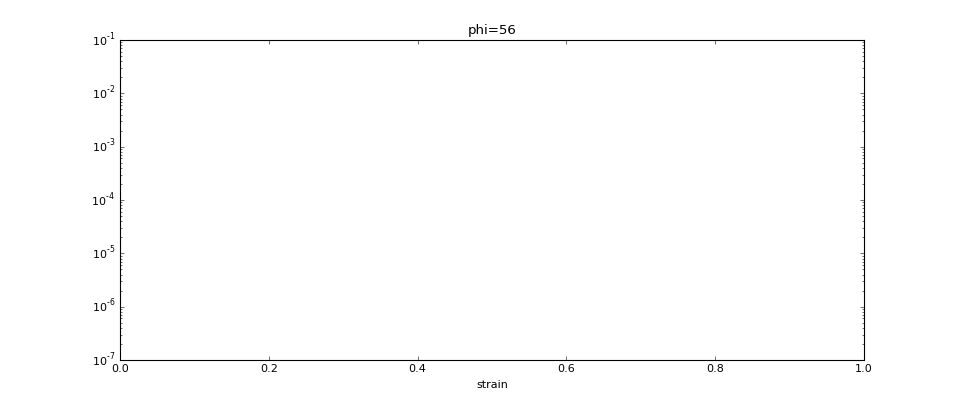

File larger_viscosity/smaller_system_size_F_CL_2e-10rhor1_phi56_yd12.5/result/nu_t.dat does not exist


In [35]:
def fetch_data(f,column):
    db = pd.read_csv(f)
    data = db[db.columns[column]]
    t = db[db.columns[1]]
    return t, data

def plot_timeseries_all_data(addpath,phival,ydvals,datatype,column):
    plt.style.use('seaborn-deep')
    plt.figure(figsize=[12,5])
    for ydval in ydvals:
        path = addpath+'rhor1_phi'+str(phival)+'_yd'+str(float(ydval))+'/result/'
        for dt in datatype:
            try:
    #         if dt in ["nu_t.dat","fluid_stress_t.dat", "part_stress_fric_t.dat", "part_stress_intfluid_t.dat",  "part_stress_norm_fric_t.dat",
    #                         "part_stress_norm_lub_t.dat",  "part_stress_norm_tot_t.dat",  "part_stress_tot_t.dat", "part_stress_hd_t.dat"    
    #                         "part_stress_lub_t.dat", "part_stress_norm_hd_t.dat", "part_stress_norm_rep_t.dat",  "part_stress_rep_t.dat"]:
                t,data  = fetch_data(path+dt, column = column)
                shearrate = float(ydval)
                shear = t*shearrate
                plt.plot(shear,data,label=str(shearrate)+" "+dt)
            except Exception as e:
                print e
                continue
    plt.legend(loc="best")
#     plt.title("phi="+str(phival)+" yd="+str(ydvals))
    plt.title("phi="+str(phival))
    plt.yscale("log")
    plt.xlabel("strain")
#     plt.ylabel(datatype)

#     plt.xlim([0,minshear])
#     name = "comparison_viscosity_" + str(phival)+ '_'.join([str(i) for i in ydvals])
#     plt.savefig(name)

plot_timeseries_all_data_widget = interactive(plot_timeseries_all_data, \
                phival = widgets.ToggleButtons(options=[20,30,35,40,45,50,54,55,56,58],value=56,disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,24,30,50,70,100,200,300,1000,2000,5000,10000], value = [12.5]), \
                datatype = widgets.SelectMultiple(options = ["nu_t.dat","fluid_stress_t.dat", "part_stress_fric_t.dat", \
                                                     "part_stress_intfluid_t.dat",  "part_stress_rep_t.dat",  \
                                                     "part_stress_tot_t.dat", "part_stress_hd_t.dat",    \
                                                        "part_stress_lub_t.dat", "part_stress_norm_hd_t.dat",\
                                                             "part_stress_norm_fric_t.dat", \
                                                     "part_stress_norm_lub_t.dat",  "part_stress_norm_tot_t.dat", \
                                                    "part_stress_norm_rep_t.dat", ],value = ["nu_t.dat",]),\
                column = widgets.IntSlider(min = 1, max = 10,value = 2),\
                addpath = widgets.Text(value = "larger_viscosity/smaller_system_size_F_CL_2e-10"),
                __manual=False)
display(plot_timeseries_all_data_widget)
# display(plot_timeseries_widget)

## Verified method

In [36]:
import cmath
disp1 = widgets.Textarea(value = "")
disp2 = widgets.Textarea(value = "")
def FFT_plot(phival,ydval,real, imag,tot,phase,tr=0):
    
    path = 'rhor1_phi'+str(phival)+'_yd'+str(float(ydval))+'/result/nu_t.dat'
    if os.path.exists(path):
        data = pd.read_csv(path)
        plt.figure(figsize=[9,9])
#         plt.subplot(411)
        plt.subplot(412)
        nu=data[data.columns[2]]
        strain = data[data.columns[1]]*ydval
        strain = np.asarray(strain)
        strainstep = strain[-1] - strain[-2]
        sp = np.fft.fft(nu)
        freq = np.fft.fftfreq(nu.shape[-1], d = strainstep )
#         _freq = np.fft.fftfreq(nu.shape[-1])
#         freq = [1.0/freqval for freqval in _freq]
        if real :plt.plot(freq, sp.real)
        if imag: plt.plot(freq, sp.imag)
        if tot:  plt.plot(freq, abs(sp))
      
        plt.xlim([-0.01,500])
#         plt.yscale("log")
        plt.ylabel("Transform")
        plt.subplot(411)
        if phase: 
            plt.plot(freq, [cmath.phase(i) for i in sp])
            print "sum of phase = ",sum( [cmath.phase(i) for i in sp])
        else:
            x, y = FT_continuous(data[data.columns[1]],data[data.columns[2]],method=1)
            if real: plt.plot(x,y.real)
            if imag: plt.plot(x,y.imag)
            if tot: plt.plot(x,abs(y))
        plt.subplot(413)
        plt.xlabel("Shear")
        plt.ylabel("Viscosity Pa.s")
        plt.yscale("log")
        _strain = data[data.columns[1]]*ydval
        plt.plot(_strain,data[data.columns[2]])
        print "points per strain =", np.ceil(len(_strain)/max(_strain))
        plt.subplot(414)
        disp1.value = str( abs(sp))
        disp2.value = str(freq)
        if tr != 0: 
            idx = []
            for f in np.sort(freq)[-tr:]:
                idx.append(np.where(freq == f)[0][0])
            sp = np.delete(sp,idx)
        else:
            yi = np.fft.ifft(sp)
            plt.plot(data[data.columns[1]]*ydval,yi)
        plt.yscale("log")
        plt.xlabel("Shear")
        plt.ylabel("Reproduced \nProfile")
    else:
        print "no such file"
FFT_plot_widget = interactive(FFT_plot, \
            phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
            ydval= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
            real = widgets.Checkbox(value=False), \
            imag = widgets.Checkbox(value = False), \
            tot= widgets.Checkbox(value = True), \
            phase= widgets.Checkbox(value = True), \
            tr = widgets.IntSlider(min =0, max=1000,value = 0),\
            __manual=False)

# map(display,FFT_plot_widget.children[:2])
# display(widgets.HBox(FFT_plot_widget.children[2:]))

## compare stress contributions

In [37]:
def LoadJSON(filename):
    file = open(filename)
    string = file.read()
    file.close()
    return json.loads(string)

def plot_stresses_viscosity(path0, items, fluid_visc,title,xlim):
    path = path0+'/result/'
    yd = float(path.split("yd")[1].split("/")[0])
    fluid = LoadJSON(path0+'/fluid_1.json')
    fluid_visc = fluid['viscshear']['constant']['nu']*1000.0
    nu_hd0_db = pd.read_csv(path+"/nu_t.dat")
    nu0 = nu_hd0_db[nu_hd0_db.columns[4]]
    time0 = nu_hd0_db[nu_hd0_db.columns[1]]*yd
    for ia in items:
        sn_tot = pd.read_csv(path+"/part_stress_"+ia+"_t.dat")
        ss = sn_tot[sn_tot.columns[2]]
        plt.plot(time0[:min(len(time0),len(ss))],[s/(yd*fluid_visc) for s in ss[:min(len(time0),len(ss))]],label="rel. visc. from "+ia)
    plt.plot(time0,nu0, label="rel.viscosity")
    plt.yscale("log")
    plt.ylim([1e-3,1e6])
    plt.xlim(xlim)
    plt.title(title,fontsize = 8)
    plt.legend(loc="best")

def plot_viscosity_contributions_ia(path1, path2, xlim, ia,visc1="1e-3", visc2="1e-2"): 
    
    plt.figure(figsize=[15,5])
    #viscosity contributions from hd, lub, fric, rep
    #0 for small fluid viscosity, 1 for high fluid viscosity
    plt.subplot(121)
    plot_stresses_viscosity(path1,ia,float(visc1),
                            "shear stresses contribution to rel. viscosity \nfor"+str(path1),xlim)
    plt.subplot(122)
    plot_stresses_viscosity(path2,ia,float(visc2),
                            "shear stresses contribution to rel. viscosity \nfor"+str(path2),xlim)

    plt.show()
    
widget_plot_viscosity_contributions_ia = interactive(plot_viscosity_contributions_ia, 
#             phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), 
#             ydval= widgets.ToggleButtons(options=[1,10,10.5,10.75,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),
            ia = widgets.SelectMultiple(options = ["rep", "fric", "hd", "lub","norm_rep", "norm_fric", "norm_hd", "norm_lub"], value= ["rep", "fric", "hd", "lub"]), 
            path1 = widgets.Text(value = "./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/rhor1_phi54_yd50.0/"), 
            path2 = widgets.Text(value = "./larger_viscosity/larger_viscosity_2x_F_CL_2e-10/rhor1_phi54_yd25.0/"), 
            xlim = widgets.IntRangeSlider(min=0,max=40,value = [0,10]),
            __manual=False)
# display(widget_plot_viscosity_contributions_ia)

<IPython.core.display.Javascript object>


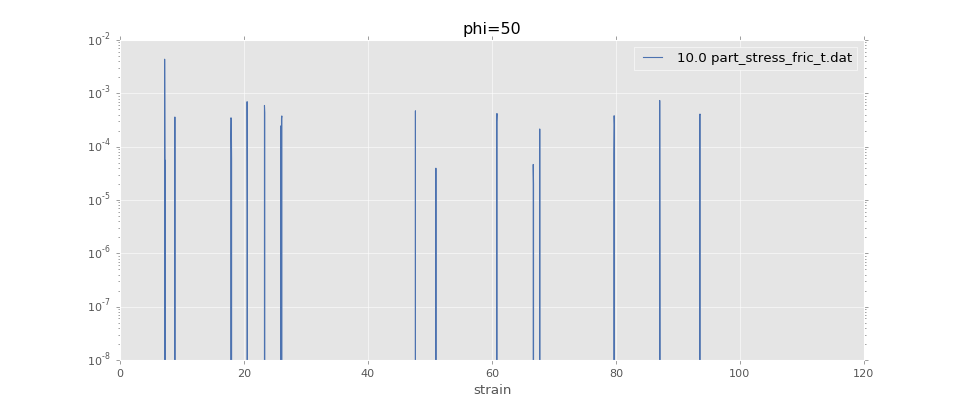

In [38]:
Tabs = widgets.Tab()
container_list = []
tab_items_input = [
                  [compare_with_hist_widget,"Compare viscosity time series with histogram"], 
                  [plot_timeseries_widget,"Compare viscosity time serieses for different shearrates"],
                 [widget_plot_viscosity_contributions_ia, "compare viscosity conntributions from 2 sources"],
                  [plot_histogram_time_series_widget,"plot viscosity histogram"],
                  [plot_timeseries_all_data_widget, "plot all available data"],
                  [plot_hist_widget,"compare viscosity histograms"],
                  [FFT_plot_widget, "fourier transform of viscosity signal"],
                  [FT_continuous_widget, "'spectral 'fft transform of viscosity signal(unverified)"],
                    ]
tab_items =  [i[0] for i in tab_items_input]
tab_name  =  [i[1] for i in tab_items_input]
for i, item in enumerate(tab_items_input): 
    container_list.append(widgets.Box())
    container_list[i].children = item[0].children
Tabs.children = tab_items
for i,name in enumerate(tab_name):
    Tabs.set_title(i,name)
        
display(Tabs)

# WC model

In [39]:
# def f(p): return (1-10**(-p))*100
# def phij(p,phim=0.58,phio=0.64): return phim*f(p) + phio*(1-f(p))
# def P(phi,yd,p): return yd*(phij(p)-phi)**-2
# pvals = np.linspace(0,10,1000)
# plt.figure()

# # plt.plot(pvals,f(pvals))
# # plt.xscale("log")

In [40]:
# def reiman(s,n=100):
#     xvals = range(1,n)
#     sum_r = sum([1.0/i**s for i in xvals])
#     return sum_r

# plt.figure()
# for s in np.linspace(-100,100,50):
#     if s!= 0: plt.plot(s,(reiman(s,1000)/np.pi**2)**(-1),'k.')

# plt.tight_layout()
# print (reiman(-2,100000))